Романовский А.Н. 22.11.2022

* Задача:

        Предобработать данные 
        Создать регрессионные модели для прогнозирования продаж.
        Оценить модели и сравнить их соответствующие оценки, такие как R2, RMSE и т. д.
_____


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
import math

In [2]:
df = pd.read_csv('Walmart.csv', parse_dates=True)

In [3]:
df.sort_values(by='Date',ascending = False, inplace=True)

In [4]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
4623,33,31-12-2010,219804.85,1,52.91,3.148,127.087677,9.265
2335,17,31-12-2010,635862.55,1,20.79,2.868,127.087677,6.885
1906,14,31-12-2010,1623716.46,1,29.67,3.179,182.571448,8.724
3479,25,31-12-2010,623092.54,1,25.89,3.179,204.643227,7.484
5624,40,31-12-2010,811318.30,1,19.29,3.177,132.815032,5.287


#### Описание столбцов:
    Store  - номер магазина
    Date - неделя продаж
    Weekly_Sales - продажи для данного магазина является целевой переменной
    Holiday_Flag - является ли неделя праздничной 1 - праздничная неделя 0 - непраздничная неделя
    Temperature - температура в день продажи
    Fuel_Price - стоимость топлива в регионе
    CPI - Преобладающий индекс потребительских цен
    Unemploymen - Преобладающий уровень безработицы
    
   #### Holiday Events\   Праздничные события
        Super Bowl \  Супер Боул: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
        Labour Day\   День труда: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
        Thanksgiving\ День Благодарения: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
        Christmas\    Рождество: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 4623 to 3921
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 452.5+ KB


In [6]:
df.nunique().sort_values()

Holiday_Flag       2
Store             45
Date             143
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [7]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

___
* Посмотрим на распеределенеие данных

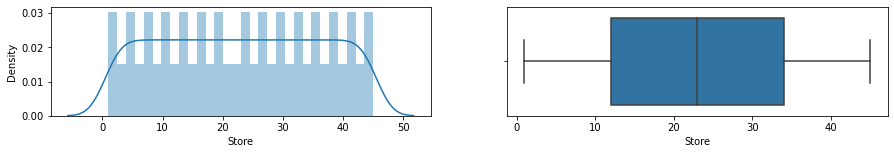

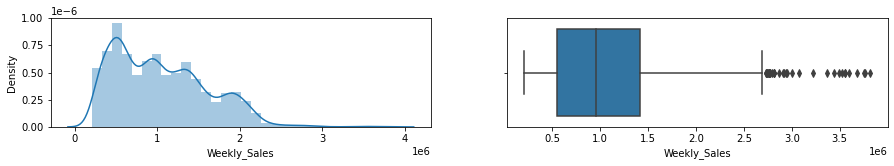

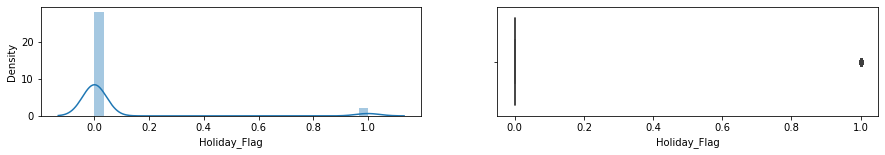

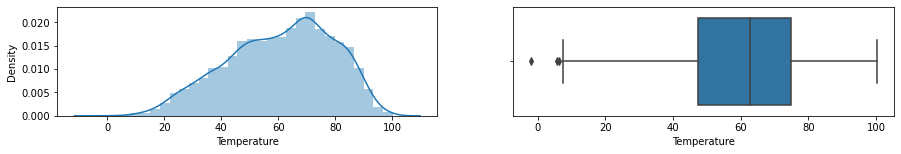

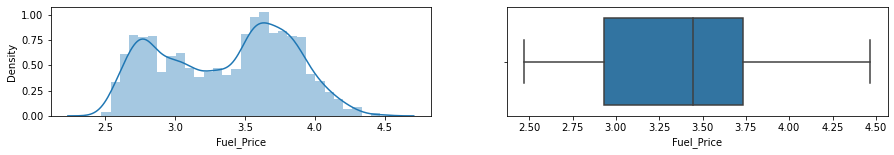

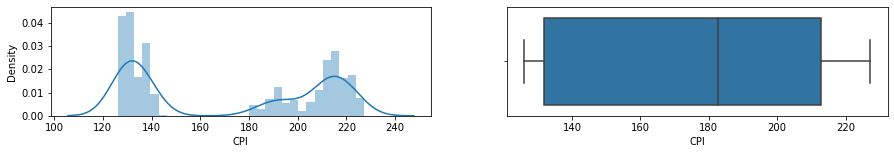

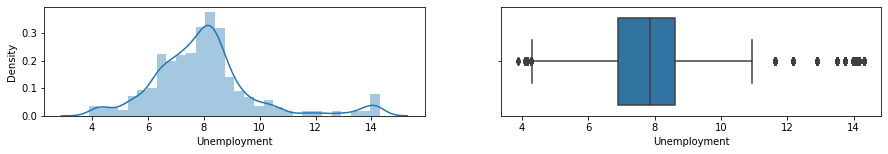

In [8]:

for i in ['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment']:
        plt.figure(figsize=(15, 2))
        sns.plotting_context(font_scale=1.5)   
        
        plt.subplot(121)
        sns.distplot(df[i], kde = True, bins = 30)

        plt.subplot(122)
        sns.boxplot(df[i])

___
* Достанем данные из колонки Data, как число, а не обьект, что бы они учитывались при построении кореляционной матрицы

In [9]:
df['Date'] = pd.to_datetime((df['Date']), infer_datetime_format=True)

In [10]:
viewDate = pd.to_datetime(df['Date']) 
df['year'] = viewDate.dt.year.astype(int) 
df['quarter'] = viewDate.dt.quarter.astype(int)
df['month'] = viewDate.dt.month.astype(int)
df['weekday'] = viewDate.dt.dayofweek.astype(int)
df['week'] = viewDate.dt.isocalendar().week.astype(int)


In [11]:
df.drop(['Date'], axis = 1, inplace= True)

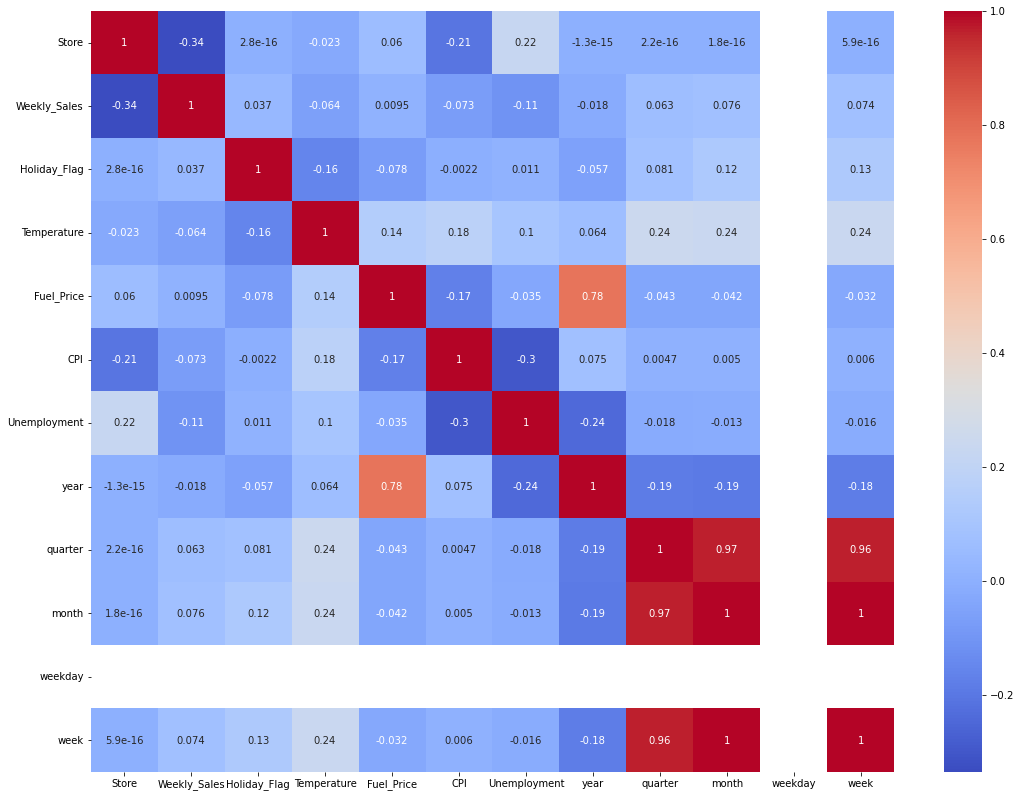

In [12]:
plt.figure(figsize=(18,14))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.show()

____
* Из матрицы видно что цена на топливо зависит от года
* Индекс безработицы и индекс потребительских цен, не имеют корреляции с обьемом продаж
* И то, что количество магазинов коррелирует с целевой переменной, в дальнейшем для колонки Store буду применять OneHotEncoder

In [13]:
grp_Holiday_Flag = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()

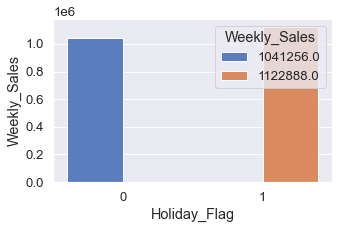

In [14]:
plt.figure(figsize=(5,3))
x = grp_Holiday_Flag.index
y = round(grp_Holiday_Flag)
sns.set(font_scale = 1.2, palette='muted')

sns.barplot(x, y, hue = y);

* Влияние Holiday_Flag, на целевую перевенную в среднем не сильно велико. Разница с флагом и без составляет 81632
* Посмотрим на распределение целевой переменной по магазаимнам 

In [15]:
grp_store = df.groupby(['Store'])['Weekly_Sales'].sum()

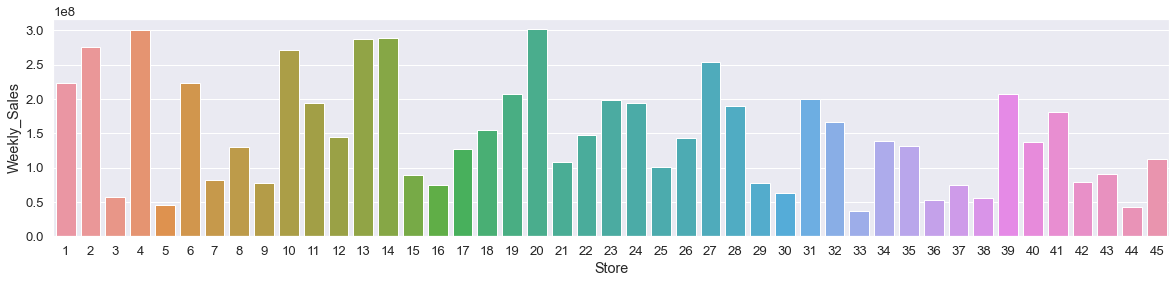

In [16]:
plt.figure(figsize=(20,4))
x = grp_store.index
y = round(grp_store)
sns.set(font_scale = 1.2, palette='muted')

sns.barplot(x, y);

* Посмотрим на средние значения Weekly_Sales по магазинам, с флагом и без

In [17]:
data = df.groupby(['Store', 'Holiday_Flag']).agg(mean_Sales=("Weekly_Sales", 'mean'))
data = data.reset_index()

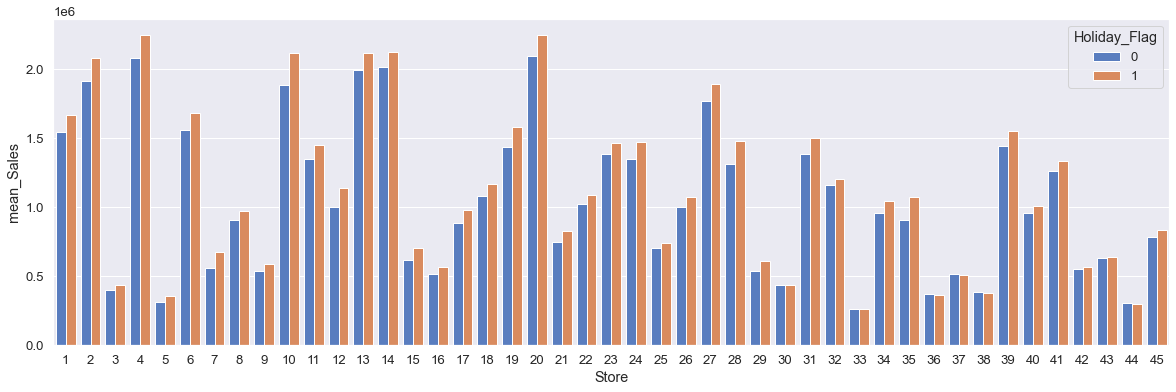

In [18]:
# plot barplot
plt.figure(figsize=(20,6))
sns.barplot(x='Store',
            y="mean_Sales",
            hue='Holiday_Flag',
            data=data);

* Оценим средние обьемы продаж, по месецам и неделям

In [19]:
grp_month = df.groupby(['month'])['Weekly_Sales'].mean()
grp_week = df.groupby(['week'])['Weekly_Sales'].mean()

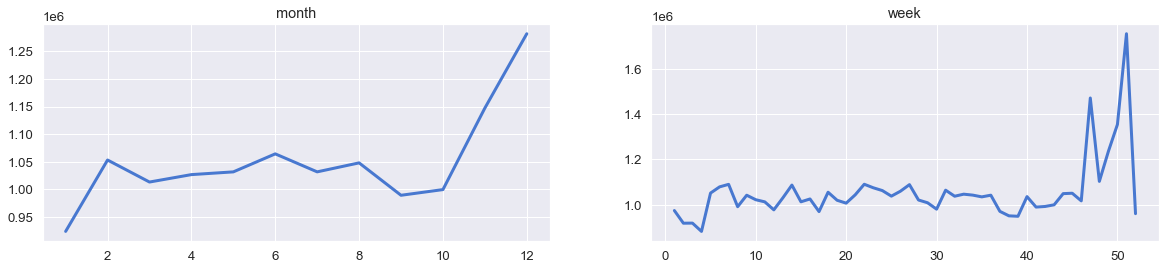

In [20]:
plt.figure(figsize=(20, 4))
plt.subplot(122)
plt.title('week')
plt.plot(grp_week, linewidth=3)

plt.subplot(121)
plt.title('month')
plt.plot(grp_month, linewidth=3)
plt.show()

_____
* Кодирование, скалирование и моделирование

In [22]:
y = df.Weekly_Sales

In [23]:
df.drop(['Weekly_Sales'], axis = 1, inplace= True)

In [24]:
df = pd.concat([df, 
                pd.get_dummies(df['Store'], prefix="Store")],
                axis = 1)

df.drop(['Store'], axis = 1, inplace= True)

In [25]:
scaled = (MinMaxScaler(feature_range=(-1,1)).fit_transform(df))
df = pd.DataFrame(scaled, columns = df.columns)

In [26]:
df.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,quarter,month,weekday,week,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1.0,0.075734,-0.322645,-0.979763,0.032394,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,-0.552838,-0.603206,-0.979763,-0.423807,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1.0,-0.379061,-0.291583,0.117092,-0.071305,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1.0,-0.453033,-0.291583,0.553428,-0.308990,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1.0,-0.582192,-0.293587,-0.866539,-0.730113,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [27]:
X_train, X_test, y_train, y_test  = train_test_split(df,y, test_size=0.2, random_state=42)

Напишем функцию для обучения и предсказания модели. И визуализации предсказаний 

In [29]:
def _model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    print(f'{model}' '\n')
    print('RMSE = ', math.sqrt(mean_squared_error(y_test, y_predict)))
    print('MSE = ',mean_squared_error(y_test, y_predict))
    print('Ср.абс.ош. = ',mean_absolute_error(y_test, y_predict))
    print('R2 = ',r2_score(y_test, y_predict))
    
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, y_predict)
    plt.plot([0, max(y_test)], [0, max(y_predict)], color = 'red') 
    plt.xlabel('y_test', fontsize=20)
    plt.ylabel('y_predict', fontsize=20);


Lasso(alpha=1)

RMSE =  166818.35282554597
MSE =  27828362839.428345
Ср.абс.ош. =  97723.4285760731
R2 =  0.9116261440294917


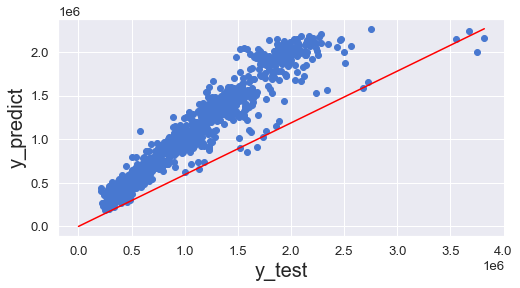

In [30]:
_model(Lasso(alpha = 1), X_train, X_test, y_train, y_test)

Ridge(alpha=1)

RMSE =  166997.96394462325
MSE =  27888319961.64968
Ср.абс.ош. =  97749.60014937317
R2 =  0.9114357396526993


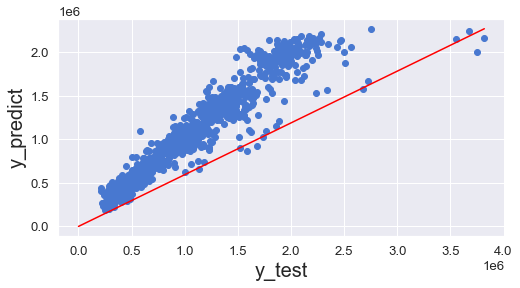

In [31]:
_model(Ridge(alpha = 1), X_train, X_test, y_train, y_test)

RandomForestRegressor()

RMSE =  114398.77493062014
MSE =  13087079705.626682
Ср.абс.ош. =  60218.47330707073
R2 =  0.9584396788394264


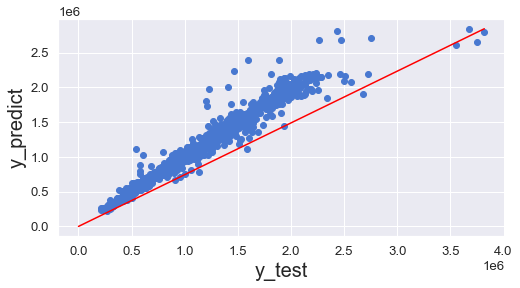

In [32]:
_model(RandomForestRegressor(), X_train, X_test, y_train, y_test)

* Отоброзим важность призноков при помощи RandomForestRegressor

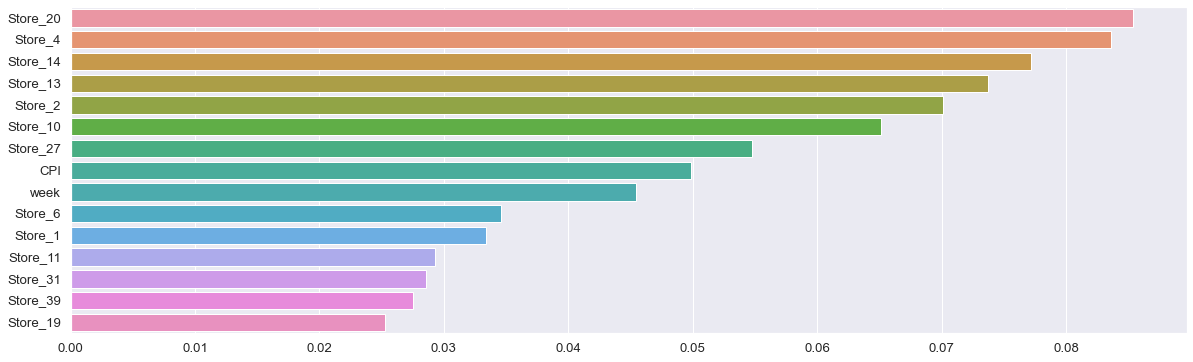

In [34]:
importances = (RandomForestRegressor().fit(X_train, y_train).feature_importances_)
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns
x =importances[indices]
y = feature_names[indices]
plt.figure(figsize=(20,6))
sns.barplot(x=x[0:15], y=y[0:15]);

#### Вывод:
* При предсказания обьема продаж, в данном наборе, самым важным является магазин.
* Наличие флага праздничной недели не сильно увеличивает обьем продаж.
* Из графиков видно, что самыме активные продажи приходятся на предпраздничные месяца(10-12)
* Максимальная точность RandomForestRegressor без OneHotEncoder составляла r2 = 0.96, c OneHotEncoder r2 = 0.958
